<a href="https://colab.research.google.com/github/nyla111/federated-learning-summer-25/blob/main/Week3_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 — Deep Neural Networks on MNIST (Step‑by‑Step)

In this notebook you will:
- Load and visualize **MNIST** digits
- Build **two models**: a simple **MLP** and a **CNN**
- Train and evaluate both, with **learning curves**, **confusion matrix**, and **error analysis**
- Peek into **learned filters** and **feature maps**
- Reflect with **study questions** at the end

**Requirements**
- Python 3.9–3.13
- `torch`, `torchvision`, `matplotlib`, `tqdm`, `numpy`, `scikit-learn` (optional for confusion matrix)

> If a package is missing, install inside your environment (e.g., `pip install torch torchvision matplotlib tqdm numpy scikit-learn`).


In [ ]:
# PURPOSE: Import libraries, set a reproducible seed, and select device (GPU if available).
# ACTION: Just run this once at the start.

import sys, math, random, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

try:
    from sklearn.metrics import confusion_matrix, classification_report
    SK_AVAILABLE = True
except Exception:
    SK_AVAILABLE = False
    print("[INFO] scikit-learn not found: confusion matrix will use a simple fallback.")

import matplotlib.pyplot as plt

def set_seed(seed: int = 42) -> None:
    """
    Set seeds for Python, NumPy, and PyTorch for reproducible results.

    Args:
        seed (int): Seed value used across libraries.
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def pick_device(prefer: str = "cuda") -> str:
    """
    Choose the compute device.

    Args:
        prefer (str): "cuda"/"gpu" to prefer GPU; "cpu" for CPU.

    Returns:
        str: "cuda" if available and requested; otherwise "cpu".
    """
    if prefer.lower() in {"cuda", "gpu"} and torch.cuda.is_available():
        return "cuda"
    return "cpu"

set_seed(42)
device = pick_device("cuda")
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")


Using device: cuda
PyTorch version: 2.6.0+cu124


100%|██████████| 9.91M/9.91M [00:00<00:00, 18.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.36MB/s]
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


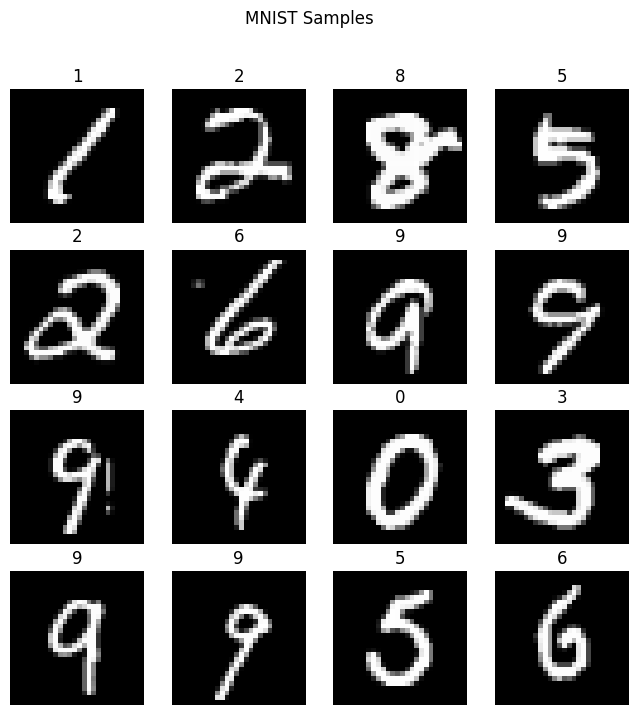

In [ ]:
# PURPOSE: Download MNIST, build DataLoaders, inspect shapes, and visualize a small gallery.
# ACTION: Run once; it will download MNIST on first run (~11 MB).

def get_mnist_loaders(batch_size: int = 128, root: str = "./data"):
    """
    Create training and validation DataLoaders for MNIST.

    Args:
        batch_size (int): Batch size for both training and validation.
        root (str): Directory to store/download the dataset.

    Returns:
        tuple[DataLoader, DataLoader]: (train_loader, val_loader)
    """
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))  # standard MNIST normalization
    ])

    train_set = datasets.MNIST(root, train=True,  download=True, transform=transform)
    val_set   = datasets.MNIST(root, train=False, download=True, transform=transform)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_set,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    return train_loader, val_loader

train_loader, val_loader = get_mnist_loaders(batch_size=128)

# Peek at a few samples (de-normalized for display)
def show_batch(loader, n: int = 16):
    """
    Show a grid of n images from a DataLoader.

    Args:
        loader (DataLoader): A PyTorch DataLoader that returns (images, labels).
        n (int): Number of images to display.
    """
    imgs, labels = next(iter(loader))
    imgs = imgs[:n].clone().detach().cpu()
    labels = labels[:n].cpu().numpy()
    # de-normalize for display
    imgs = imgs * 0.3081 + 0.1307

    grid_cols = int(math.sqrt(n))
    grid_rows = int(math.ceil(n / grid_cols))
    plt.figure(figsize=(grid_cols * 2, grid_rows * 2))
    for i in range(n):
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(imgs[i].squeeze(0), cmap="gray")
        plt.title(str(labels[i]))
        plt.axis("off")
    plt.suptitle("MNIST Samples")
    plt.show()

show_batch(train_loader, n=16)


In [ ]:
# PURPOSE: Define accuracy, training history container, and plotting helpers (loss & accuracy curves; confusion matrix).
# ACTION: Run once; these utilities are used later.

@torch.no_grad()
def accuracy_top1(logits: torch.Tensor, targets: torch.Tensor) -> float:
    """
    Compute Top-1 accuracy.

    Args:
        logits (Tensor): Model outputs of shape (N, C).
        targets (Tensor): Ground-truth class indices of shape (N,).

    Returns:
        float: Average accuracy in [0, 1].
    """
    preds = logits.argmax(dim=1)
    return (preds == targets).float().mean().item()

class History:
    """
    Store training/validation metrics over epochs and provide simple append semantics.

    Attributes:
        epochs (list[int]): Epoch indices (1-based).
        train_loss (list[float]), val_loss (list[float]): Loss history.
        train_acc (list[float]),  val_acc (list[float]): Accuracy history.
    """
    def __init__(self):
        self.epochs = []
        self.train_loss, self.val_loss = [], []
        self.train_acc,  self.val_acc  = [], []

def plot_history(hist: History, title: str = "Learning Curves"):
    """
    Plot loss and accuracy curves from a History object.

    Args:
        hist (History): Collected metrics.
        title (str): Title for the figure.

    Notes:
        - Uses matplotlib only (no seaborn).
        - Each chart uses its own figure as requested.
    """
    # Loss
    plt.figure(figsize=(6,4))
    plt.plot(hist.epochs, hist.train_loss, label="train loss")
    plt.plot(hist.epochs, hist.val_loss,   label="val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} — Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

    # Accuracy
    plt.figure(figsize=(6,4))
    plt.plot(hist.epochs, hist.train_acc, label="train acc")
    plt.plot(hist.epochs, hist.val_acc,   label="val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} — Accuracy")
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(y_true, y_pred, num_classes: int = 10, normalize: bool = True, title: str = "Confusion Matrix"):
    """
    Plot a confusion matrix heatmap.

    Args:
        y_true (array-like): Ground-truth integer labels.
        y_pred (array-like): Predicted integer labels.
        num_classes (int): Number of classes.
        normalize (bool): Divide rows by row sums if True.
        title (str): Title for the plot.
    """
    import numpy as _np
    if SK_AVAILABLE:
        cm = confusion_matrix(y_true, y_pred, labels=_np.arange(num_classes))
    else:
        cm = _np.zeros((num_classes, num_classes), dtype=int)
        for t, p in zip(y_true, y_pred):
            cm[t, p] += 1

    cm = cm.astype(float)
    if normalize:
        row_sums = cm.sum(axis=1, keepdims=True) + 1e-12
        cm = cm / row_sums

    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xlabel("Predicted"); plt.ylabel("True")
    plt.colorbar()
    # tick labels 0..9
    ticks = list(range(num_classes))
    plt.xticks(ticks, ticks, rotation=0)
    plt.yticks(ticks, ticks)
    plt.tight_layout()
    plt.show()


In [ ]:
# Purpose: Keep interfaces consistent across models and data.
# Action: Run once; these are imported by later classes.

import torch.nn as nn
from typing import Callable, Tuple
from torch.utils.data import DataLoader

class Module(nn.Module):
    """
    Light wrapper around `torch.nn.Module` that adds a parameter counter.

    Methods:
        num_params(trainable_only=True) -> int: Count the model parameters.
    """
    def num_params(self, trainable_only: bool = True) -> int:
        """
        Count the number of parameters in the model.

        Args:
            trainable_only (bool): If True, count only parameters with requires_grad=True.

        Returns:
            int: Parameter count according to the filter.
        """
        if trainable_only:
            return sum(p.numel() for p in self.parameters() if p.requires_grad)
        return sum(p.numel() for p in self.parameters())

class DataModule:
    """
    Simple wrapper that holds train and validation loaders produced by a given factory.

    Args:
        loader_fn (Callable[..., Tuple[DataLoader, DataLoader]]): Function returning (train_loader, val_loader).
        **loader_kwargs: Keyword arguments forwarded to the loader function.

    Attributes:
        train_loader (DataLoader): Training data loader.
        val_loader   (DataLoader): Validation data loader.
    """
    def __init__(self, loader_fn: Callable[..., Tuple[DataLoader, DataLoader]], **loader_kwargs):
        self.train_loader, self.val_loader = loader_fn(**loader_kwargs)


In [ ]:
# PURPOSE: Define two MNIST models — a fully-connected MLP and a small CNN — with docstrings.
# ACTION: Run once; you'll instantiate these in the training cells.

class MLP(Module):
    """
    A simple Multi-Layer Perceptron for 28x28 MNIST digits.

    Architecture:
        Flatten(28*28) -> Linear(784->512) -> ReLU -> Dropout
                        -> Linear(512->256) -> ReLU -> Dropout
                        -> Linear(256->10)

    Args:
        hidden1 (int): Units in the first hidden layer.
        hidden2 (int): Units in the second hidden layer.
        dropout (float): Dropout probability applied after hidden layers.
        num_classes (int): Number of classes (10 for MNIST).
    """
    def __init__(self, hidden1: int = 512, hidden2: int = 256, dropout: float = 0.2, num_classes: int = 10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, hidden1), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(hidden1, hidden2), nn.ReLU(inplace=True), nn.Dropout(dropout),
            nn.Linear(hidden2, num_classes)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x (Tensor): Input images of shape (N, 1, 28, 28).

        Returns:
            Tensor: Logits of shape (N, 10).
        """
        return self.net(x)

class SimpleCNN(Module):
    """
    A compact CNN for MNIST.

    Architecture:
        Conv(1->32,3) -> BN -> ReLU
        Conv(32->64,3) -> BN -> ReLU -> MaxPool(2)
        Dropout
        Conv(64->128,3) -> BN -> ReLU -> GlobalAvgPool
        Linear(128->10)

    Args:
        num_classes (int): Number of classes (10 for MNIST).
        dropout (float): Dropout probability before final block.
    """
    def __init__(self, num_classes: int = 10, dropout: float = 0.25):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(64), nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False), nn.BatchNorm2d(128), nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass.

        Args:
            x (Tensor): Input images of shape (N, 1, 28, 28).

        Returns:
            Tensor: Logits of shape (N, 10).
        """
        x = self.features(x)
        x = x.flatten(1)
        return self.classifier(x)

# quick sanity check on param counts
mlp_params = MLP().num_params()
cnn_params = SimpleCNN().num_params()
print(f"MLP params: {mlp_params:,} | CNN params: {cnn_params:,}")


MLP params: 535,818 | CNN params: 94,186


In [ ]:
# PURPOSE: Define reusable training/evaluation loops with AMP support and history tracking.
# ACTION: Run once; then call train_model(...) for each model you want to train.

from torch.optim import SGD, AdamW
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer, device: str, scaler: GradScaler) -> tuple[float, float]:
    """
    Train the model for one epoch.

    Args:
        model (nn.Module): Model to train.
        loader (DataLoader): Training DataLoader yielding (images, labels).
        optimizer (Optimizer): Torch optimizer.
        device (str): "cuda" or "cpu".
        scaler (GradScaler): Mixed-precision scaler for stable AMP training.

    Returns:
        tuple[float, float]: (avg_loss, avg_accuracy) over the epoch.
    """
    model.train()
    total_loss, total_correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()
    for x, y in tqdm(loader, desc="Train", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=(device == "cuda")):
            logits = model(x)
            loss = criterion(logits, y)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item() * y.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)

    return total_loss / total, total_correct / total

@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: str) -> tuple[float, float, np.ndarray, np.ndarray]:
    """
    Evaluate the model and collect predictions for confusion matrix.

    Args:
        model (nn.Module): Trained/partially-trained model.
        loader (DataLoader): Validation DataLoader.
        device (str): "cuda" or "cpu".

    Returns:
        tuple[float, float, np.ndarray, np.ndarray]:
            (avg_loss, avg_accuracy, y_true_all, y_pred_all)
    """
    model.eval()
    total_loss, total_correct, total = 0.0, 0, 0
    criterion = nn.CrossEntropyLoss()
    all_true, all_pred = [], []
    for x, y in tqdm(loader, desc="Eval ", leave=False):
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)
        total_loss += loss.item() * y.size(0)
        preds = logits.argmax(dim=1)
        total_correct += (preds == y).sum().item()
        total += y.size(0)
        all_true.append(y.cpu().numpy())
        all_pred.append(preds.cpu().numpy())
    y_true = np.concatenate(all_true)
    y_pred = np.concatenate(all_pred)
    return total_loss / total, total_correct / total, y_true, y_pred

def train_model(model: nn.Module, train_loader: DataLoader, val_loader: DataLoader,
                device: str, epochs: int = 5, lr: float = 0.01, optimizer_name: str = "adamw") -> tuple[History, np.ndarray, np.ndarray]:
    """
    Full training loop with validation per epoch and history tracking.

    Args:
        model (nn.Module): Model instance (MLP or CNN).
        train_loader (DataLoader): Training data.
        val_loader (DataLoader): Validation data.
        device (str): "cuda" or "cpu".
        epochs (int): Number of epochs to train.
        lr (float): Learning rate.
        optimizer_name (str): "adamw" or "sgd".

    Returns:
        tuple[History, np.ndarray, np.ndarray]: (history, y_true, y_pred) for the final epoch on validation set.
    """
    model = model.to(device)
    scaler = GradScaler(enabled=(device == "cuda"))
    if optimizer_name.lower() == "sgd":
        optimizer = SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    else:
        optimizer = AdamW(model.parameters(), lr=lr, weight_decay=1e-2)

    hist = History()
    for ep in range(1, epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, device, scaler)
        val_loss, val_acc, y_true, y_pred = evaluate(model, val_loader, device)

        hist.epochs.append(ep)
        hist.train_loss.append(train_loss)
        hist.train_acc.append(train_acc)
        hist.val_loss.append(val_loss)
        hist.val_acc.append(val_acc)

        print(f"Epoch {ep:02d}/{epochs} | "
              f"train: loss={train_loss:.4f}, acc={train_acc:.4f} | "
              f"val: loss={val_loss:.4f}, acc={val_acc:.4f}")

    return hist, y_true, y_pred


/tmp/ipython-input-3003555921.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))
Train:   0%|          | 0/469 [00:00<?, ?it/s]/tmp/ipython-input-3003555921.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 01/5 | train: loss=0.2598, acc=0.9208 | val: loss=0.1077, acc=0.9670


Epoch 02/5 | train: loss=0.1142, acc=0.9651 | val: loss=0.0879, acc=0.9717


Epoch 03/5 | train: loss=0.0823, acc=0.9747 | val: loss=0.0739, acc=0.9765


Epoch 04/5 | train: loss=0.0669, acc=0.9788 | val: loss=0.0695, acc=0.9788


Epoch 05/5 | train: loss=0.0547, acc=0.9821 | val: loss=0.0699, acc=0.9793


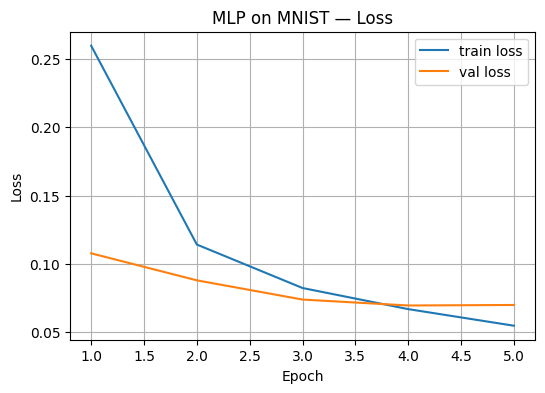

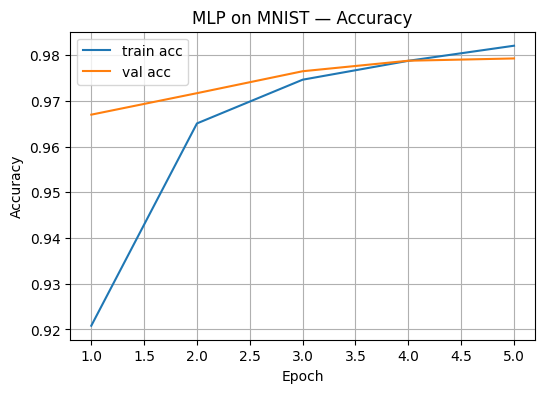

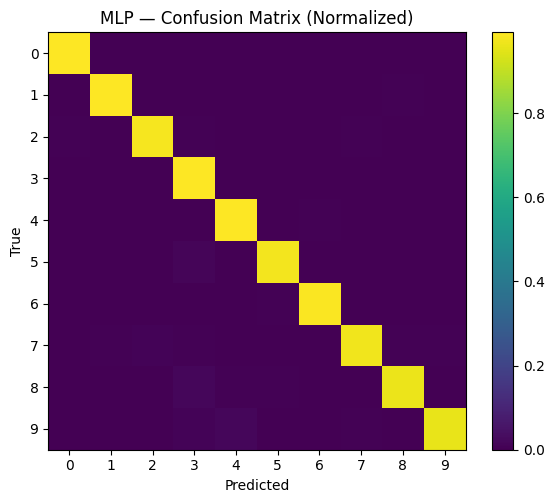

Classification report (MLP):
              precision    recall  f1-score   support

           0     0.9838    0.9918    0.9878       980
           1     0.9903    0.9912    0.9908      1135
           2     0.9863    0.9797    0.9830      1032
           3     0.9515    0.9911    0.9709      1010
           4     0.9700    0.9888    0.9793       982
           5     0.9819    0.9753    0.9786       892
           6     0.9885    0.9843    0.9864       958
           7     0.9794    0.9689    0.9741      1028
           8     0.9760    0.9620    0.9690       974
           9     0.9857    0.9584    0.9719      1009

    accuracy                         0.9793     10000
   macro avg     0.9794    0.9792    0.9792     10000
weighted avg     0.9795    0.9793    0.9793     10000



In [ ]:
# PURPOSE: Train the MLP baseline for a few epochs and plot its learning curves and confusion matrix.
# ACTION: Run; tweak epochs/lr if you want faster or better accuracy.

mlp = MLP()
mlp_hist, mlp_true, mlp_pred = train_model(
    mlp, train_loader, val_loader, device=device,
    epochs=5, lr=1e-3, optimizer_name="adamw"
)

plot_history(mlp_hist, title="MLP on MNIST")
plot_confusion_matrix(mlp_true, mlp_pred, num_classes=10, normalize=True, title="MLP — Confusion Matrix (Normalized)")

if SK_AVAILABLE:
    print("Classification report (MLP):")
    print(classification_report(mlp_true, mlp_pred, digits=4))


/tmp/ipython-input-3003555921.py:90: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=(device == "cuda"))
Train:   0%|          | 0/469 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/tmp/ipython-input-3003555921.py:27: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=(device == "cuda")):


Epoch 01/5 | train: loss=1.3979, acc=0.5854 | val: loss=0.7610, acc=0.8217


Epoch 02/5 | train: loss=0.5109, acc=0.8872 | val: loss=0.2971, acc=0.9385


Epoch 03/5 | train: loss=0.2714, acc=0.9377 | val: loss=0.1930, acc=0.9584


Epoch 04/5 | train: loss=0.1944, acc=0.9530 | val: loss=0.1860, acc=0.9537


Epoch 05/5 | train: loss=0.1605, acc=0.9604 | val: loss=0.1386, acc=0.9635


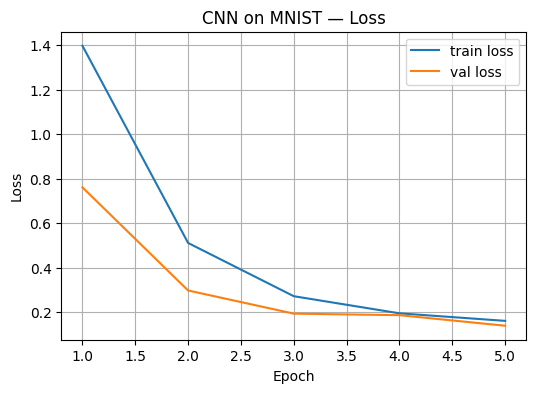

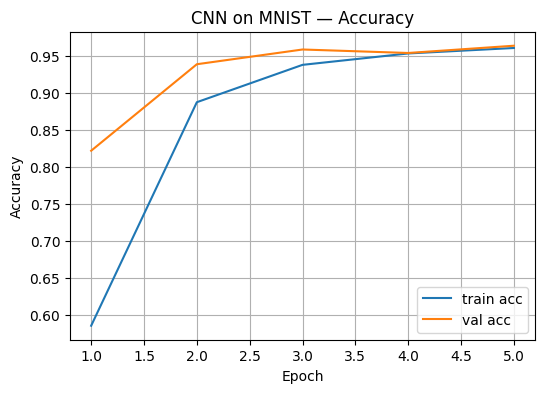

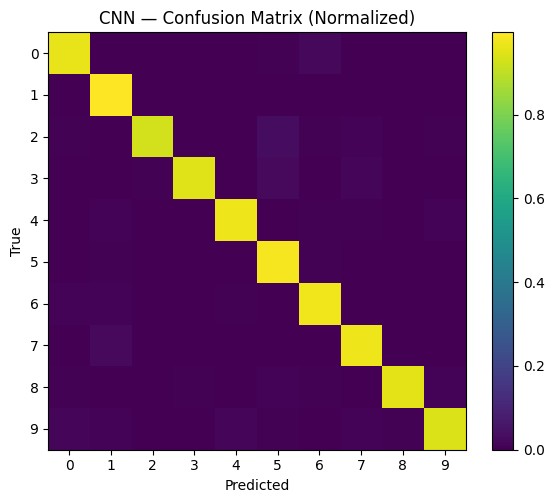

Classification report (CNN):
              precision    recall  f1-score   support

           0     0.9682    0.9643    0.9663       980
           1     0.9480    0.9965    0.9716      1135
           2     0.9816    0.9293    0.9547      1032
           3     0.9876    0.9475    0.9672      1010
           4     0.9734    0.9705    0.9720       982
           5     0.9125    0.9821    0.9460       892
           6     0.9550    0.9739    0.9643       958
           7     0.9578    0.9718    0.9648      1028
           8     0.9862    0.9559    0.9708       974
           9     0.9684    0.9425    0.9553      1009

    accuracy                         0.9635     10000
   macro avg     0.9639    0.9634    0.9633     10000
weighted avg     0.9642    0.9635    0.9635     10000



In [ ]:
# PURPOSE: Train the CNN for a few epochs and visualize its results similarly.
# ACTION: Run; the CNN should outperform the MLP on MNIST.

cnn = SimpleCNN()
cnn_hist, cnn_true, cnn_pred = train_model(
    cnn, train_loader, val_loader, device=device,
    epochs=5, lr=1e-2, optimizer_name="sgd"   # SGD often works well for CNNs here
)

plot_history(cnn_hist, title="CNN on MNIST")
plot_confusion_matrix(cnn_true, cnn_pred, num_classes=10, normalize=True, title="CNN — Confusion Matrix (Normalized)")

if SK_AVAILABLE:
    print("Classification report (CNN):")
    print(classification_report(cnn_true, cnn_pred, digits=4))


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


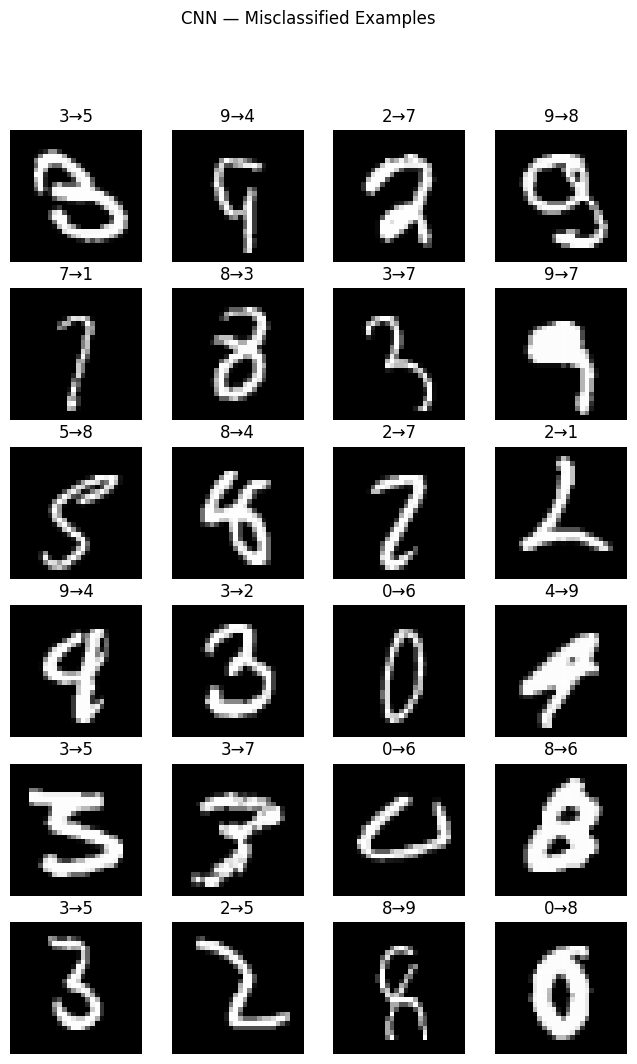

In [ ]:
# PURPOSE: Show a grid of misclassified digits to understand failure modes.
# ACTION: Run after training CNN (or MLP). You can switch which predictions to display.

def show_misclassified(model: nn.Module, loader: DataLoader, device: str, n: int = 24, title: str = "Misclassified"):
    """
    Display a grid of misclassified samples with (true→pred) labels.

    Args:
        model (nn.Module): Trained model.
        loader (DataLoader): Validation loader.
        device (str): "cuda" or "cpu".
        n (int): How many examples to display (will show min(n, #errors)).
        title (str): Figure title.
    """
    model.eval()
    xs, ts, ps = [], [], []
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            logits = model(x)
            pred = logits.argmax(dim=1).cpu()
            y = y.cpu()
            mism = pred.ne(y)
            if mism.any():
                xs.append(x.cpu()[mism])
                ts.append(y[mism])
                ps.append(pred[mism])
            if sum(t.size(0) for t in ts) >= n:
                break
    if not xs:
        print("No misclassifications found (perfect accuracy on sampled batch)!")
        return

    xs = torch.cat(xs)[:n]
    ts = torch.cat(ts)[:n].numpy()
    ps = torch.cat(ps)[:n].numpy()
    imgs = xs * 0.3081 + 0.1307  # de-normalize

    grid_cols = int(math.sqrt(n))
    grid_rows = int(math.ceil(n / grid_cols))
    plt.figure(figsize=(grid_cols * 2, grid_rows * 2))
    for i in range(xs.size(0)):
        plt.subplot(grid_rows, grid_cols, i + 1)
        plt.imshow(imgs[i].squeeze(0), cmap="gray")
        plt.title(f"{ts[i]}→{ps[i]}")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()

# Show CNN errors (change to `mlp` to see MLP errors)
show_misclassified(cnn, val_loader, device, n=24, title="CNN — Misclassified Examples")


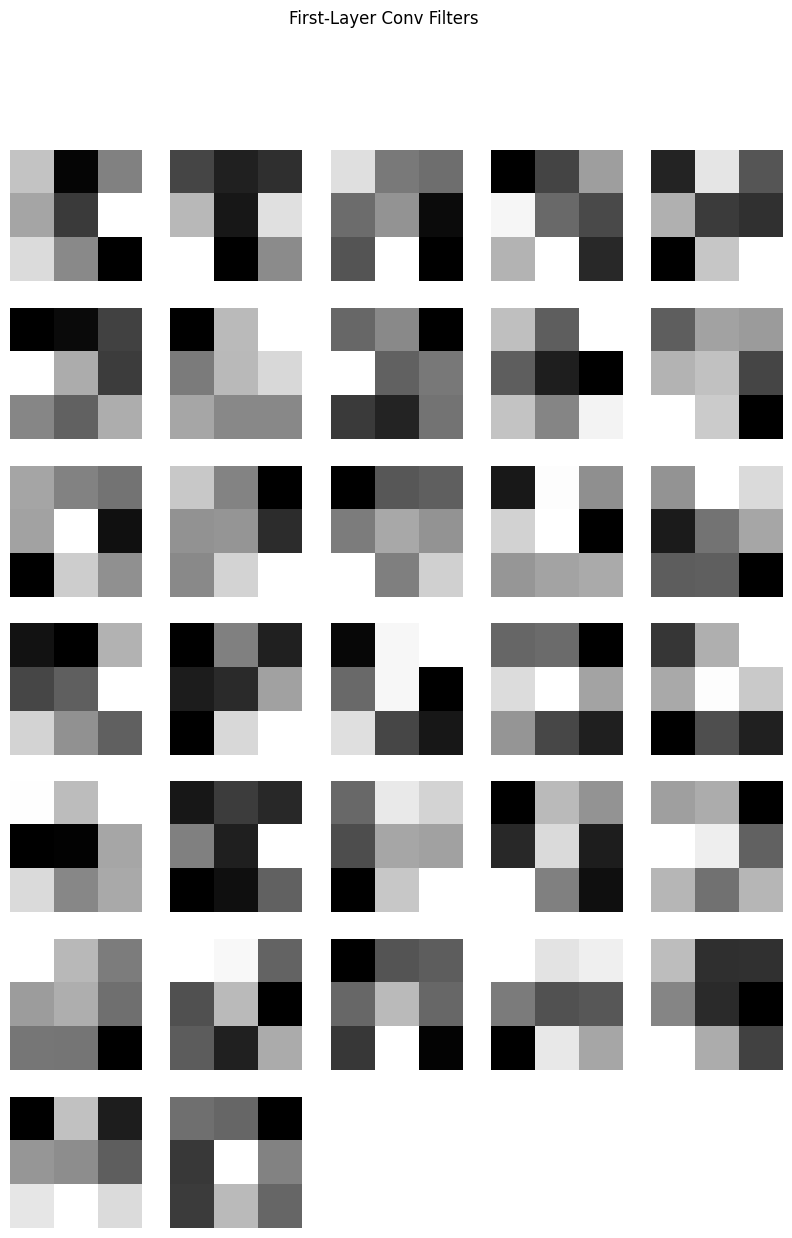

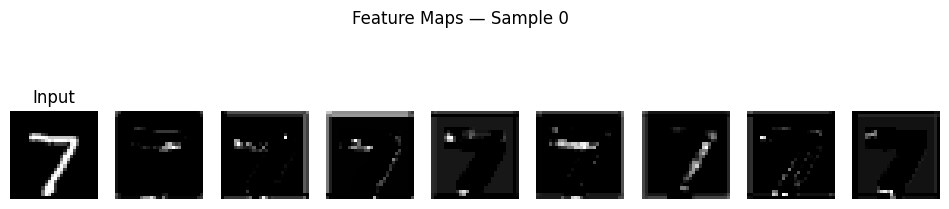

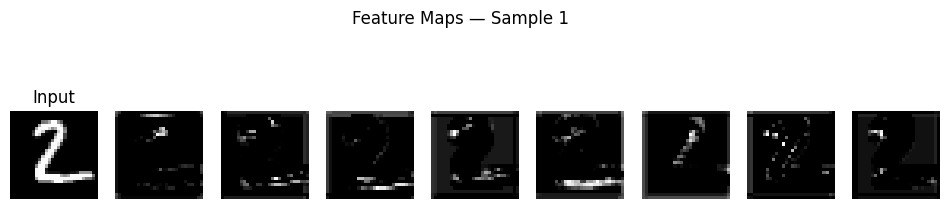

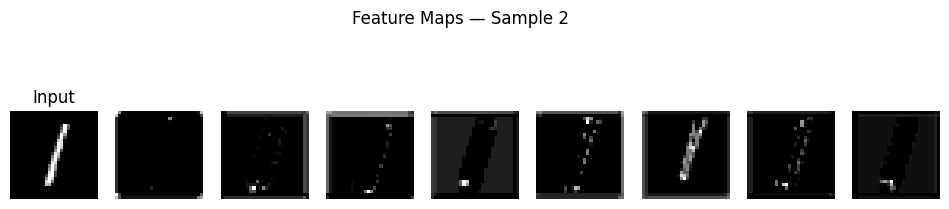

In [ ]:
# PURPOSE: Visualize first-layer filters and feature maps for a few inputs.
# ACTION: Run after training. These plots help build intuition about convolutional features.

def visualize_first_layer_filters(model: SimpleCNN, max_k: int = 32):
    """
    Visualize learned convolutional filters from the first conv layer.

    Args:
        model (SimpleCNN): Trained CNN model.
        max_k (int): Maximum number of filters to display.
    """
    with torch.no_grad():
        conv = None
        # find the first Conv2d module
        for m in model.features:
            if isinstance(m, nn.Conv2d):
                conv = m
                break
        if conv is None:
            print("No Conv2d layer found.")
            return
        w = conv.weight.detach().cpu()  # shape (out_channels, in_channels=1, kH, kW) for MNIST
        k = min(w.size(0), max_k)

        grid_cols = int(math.sqrt(k))
        grid_rows = int(math.ceil(k / grid_cols))
        plt.figure(figsize=(grid_cols * 2, grid_rows * 2))
        for i in range(k):
            plt.subplot(grid_rows, grid_cols, i + 1)
            # normalize per-filter for visualization
            filt = w[i, 0]
            filt = (filt - filt.min()) / (filt.max() - filt.min() + 1e-8)
            plt.imshow(filt.numpy(), cmap="gray")
            plt.axis("off")
        plt.suptitle("First-Layer Conv Filters")
        plt.show()

def visualize_feature_maps(model: SimpleCNN, loader: DataLoader, device: str, n_images: int = 4):
    """
    Show feature maps after the first conv block for a few images.

    Args:
        model (SimpleCNN): Trained CNN model.
        loader (DataLoader): Data loader to sample inputs from.
        device (str): "cuda" or "cpu".
        n_images (int): Number of images to visualize.
    """
    # hook to capture outputs
    activations = []
    def hook_fn(m, i, o):
        activations.append(o.detach().cpu())

    # register hook on the second ReLU (after two convs) to see "edge-like" maps
    relu_target = None
    relu_count = 0
    for m in model.features:
        if isinstance(m, nn.ReLU):
            relu_count += 1
            if relu_count == 2:
                relu_target = m
                break
    if relu_target is None:
        print("Could not find target ReLU for feature visualization.")
        return
    handle = relu_target.register_forward_hook(hook_fn)

    model.eval()
    imgs, labels = next(iter(loader))
    imgs = imgs[:n_images].to(device)
    with torch.no_grad():
        _ = model(imgs)

    handle.remove()

    # visualize a few channels per image
    fm = activations[0]  # shape (N, C, H, W)
    N, C, H, W = fm.shape
    channels_to_show = min(8, C)

    # de-normalize inputs for display
    imgs_vis = imgs.cpu() * 0.3081 + 0.1307

    for idx in range(min(N, n_images)):
        plt.figure(figsize=(12, 3))
        # original image
        plt.subplot(1, channels_to_show + 1, 1)
        plt.imshow(imgs_vis[idx].squeeze(0), cmap="gray")
        plt.title("Input")
        plt.axis("off")

        # first few feature maps
        for c in range(channels_to_show):
            plt.subplot(1, channels_to_show + 1, 2 + c)
            fmap = fm[idx, c]
            fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
            plt.imshow(fmap.numpy(), cmap="gray")
            plt.axis("off")
        plt.suptitle(f"Feature Maps — Sample {idx}")
        plt.show()

# Visualize CNN internals
visualize_first_layer_filters(cnn, max_k=32)
visualize_feature_maps(cnn, val_loader, device, n_images=3)
